# Fraud detection in Mobile Payments

This repository contains a trained machine learning model for detecting fraudulent financial transactions. The model is saved as a `.pkl` file for easy loading and integration into applications such as Streamlit dashboards, APIs, or other real-time systems.

## **Overview**

The fraud detection model was trained using a synthetic dataset of financial transactions. The model predicts whether a transaction is **fraudulent** or **legitimate** based on several key features like transaction type, amount, and account balances.


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ealaxi/paysim1")

print("Path to dataset files:", path)

100%|██████████| 178M/178M [00:01<00:00, 140MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/ealaxi/paysim1/versions/2


In [ ]:
!kaggle datasets download -d ealaxi/paysim1


Dataset URL: https://www.kaggle.com/datasets/ealaxi/paysim1
License(s): CC-BY-SA-4.0
 94% 167M/178M [00:01<00:00, 115MB/s]
100% 178M/178M [00:01<00:00, 98.1MB/s]


In [ ]:
!unzip paysim1.zip -d /content


Archive:  paysim1.zip
  inflating: /content/PS_20174392719_1491204439457_log.csv  


The following features were used to train the model:

- **`step`**: Time in hours since the start of the simulation.
- **`type`**: Type of transaction (e.g., CASH-IN, CASH-OUT, TRANSFER, PAYMENT, DEBIT).
- **`amount`**: Amount of the transaction in local currency.
- **`oldbalanceOrg`**: Initial balance of the sender before the transaction.
- **`newbalanceOrig`**: New balance of the sender after the transaction.
- **`oldbalanceDest`**: Initial balance of the recipient before the transaction.
- **`newbalanceDest`**: New balance of the recipient after the transaction.
- **`isFlaggedFraud`**: Whether the transaction was flagged as suspicious based on business rules.


In [ ]:
import pandas as pd

df = pd.read_csv("/content/PS_20174392719_1491204439457_log.csv")
df.head()


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


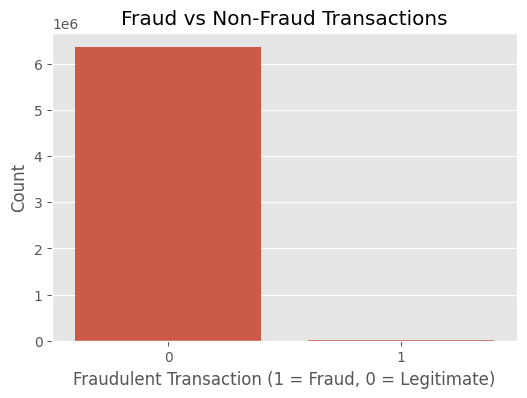

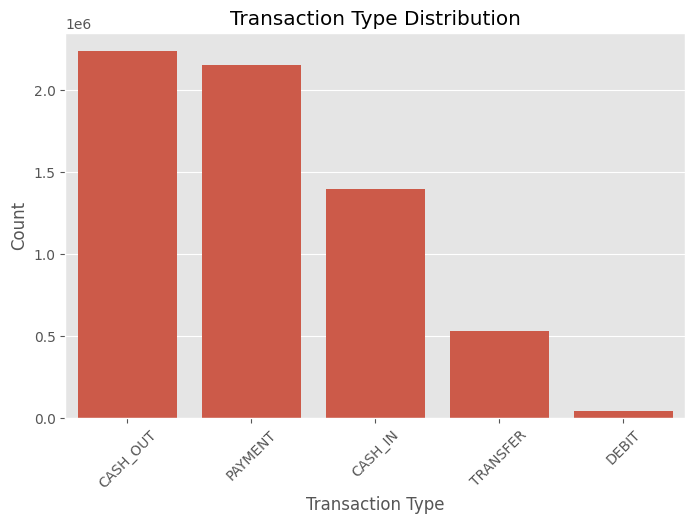

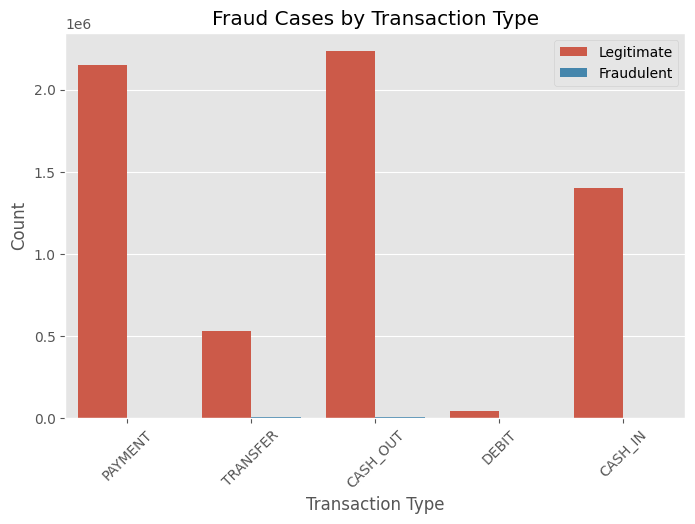

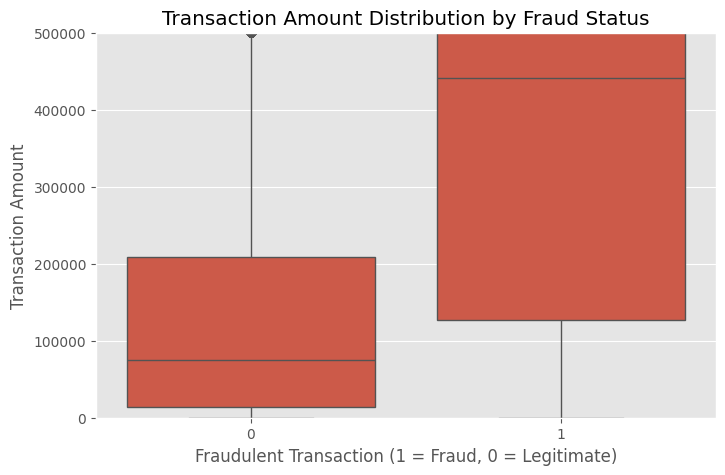

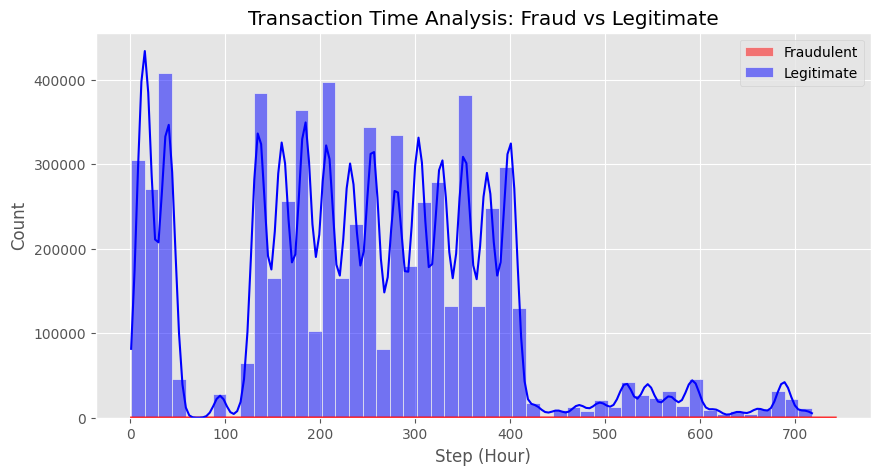

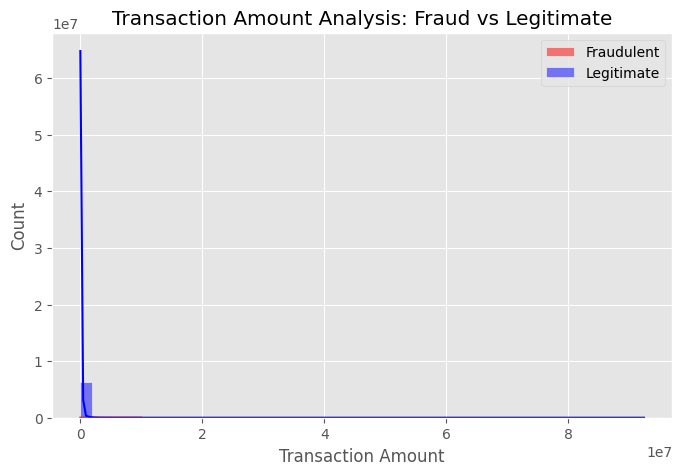

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
plt.style.use("ggplot")

# Fraud distribution
plt.figure(figsize=(6, 4))
sns.countplot(x=df["isFraud"])
plt.title("Fraud vs Non-Fraud Transactions")
plt.xlabel("Fraudulent Transaction (1 = Fraud, 0 = Legitimate)")
plt.ylabel("Count")
plt.show()

# Transaction Type Distribution
plt.figure(figsize=(8, 5))
sns.countplot(x=df["type"], order=df["type"].value_counts().index)
plt.title("Transaction Type Distribution")
plt.xlabel("Transaction Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

# Fraud Count by Transaction Type
plt.figure(figsize=(8, 5))
sns.countplot(x=df["type"], hue=df["isFraud"])
plt.title("Fraud Cases by Transaction Type")
plt.xlabel("Transaction Type")
plt.ylabel("Count")
plt.legend(["Legitimate", "Fraudulent"])
plt.xticks(rotation=45)
plt.show()

# Boxplot of Transaction Amount by Fraud Status
plt.figure(figsize=(8, 5))
sns.boxplot(x=df["isFraud"], y=df["amount"])
plt.title("Transaction Amount Distribution by Fraud Status")
plt.xlabel("Fraudulent Transaction (1 = Fraud, 0 = Legitimate)")
plt.ylabel("Transaction Amount")
plt.ylim(0, 500000)  # Set limit for better visualization
plt.show()

# Fraud Cases by Step (Time Analysis)
plt.figure(figsize=(10, 5))
sns.histplot(df[df["isFraud"] == 1]["step"], bins=50, kde=True, color='red', label="Fraudulent")
sns.histplot(df[df["isFraud"] == 0]["step"], bins=50, kde=True, color='blue', label="Legitimate", alpha=0.5)
plt.title("Transaction Time Analysis: Fraud vs Legitimate")
plt.xlabel("Step (Hour)")
plt.ylabel("Count")
plt.legend()
plt.show()

# Fraud Cases by Transaction Amount
plt.figure(figsize=(8, 5))
sns.histplot(df[df["isFraud"] == 1]["amount"], bins=50, kde=True, color='red', label="Fraudulent")
sns.histplot(df[df["isFraud"] == 0]["amount"], bins=50, kde=True, color='blue', label="Legitimate", alpha=0.5)
plt.title("Transaction Amount Analysis: Fraud vs Legitimate")
plt.xlabel("Transaction Amount")
plt.ylabel("Count")
plt.legend()
plt.show()


## 1. **Fraud vs. Non-Fraud Transactions**

**Key Insights**:
  - The dataset is highly **imbalanced**.
  - Legitimate transactions dominate the dataset, making up nearly all the entries.
  - Fraudulent transactions are a very small percentage, posing a challenge for detection models.

## 2. **Transaction Type Distribution**
**Key Insights**:
  - **CASH-OUT** and **PAYMENT** transactions are the most common types, followed by **CASH-IN**.
  - **TRANSFER** transactions are less frequent but are critical as they are associated with fraudulent activity (see the next chart).
  - **DEBIT** transactions are rare.

## 3. **Fraud Cases by Transaction Type**
**Key Insights**:
  - Fraud is concentrated in **TRANSFER** and **CASH-OUT** transactions.
  - **PAYMENT**, **CASH-IN**, and **DEBIT** transactions show almost no fraudulent cases.
  - This indicates that fraudsters primarily use **TRANSFER** and **CASH-OUT** to move and withdraw funds.

## 4. **Transaction Amount Distribution by Fraud Status**

**Key Insights**:
  - Fraudulent transactions typically involve **higher amounts** than legitimate ones.
  - Legitimate transactions have a lower median transaction amount and a narrower range.
  - This suggests that **large transactions** are more likely to be fraudulent.

## 5. **Transaction Time Analysis: Fraud vs. Legitimate**

**Key Insights**:
  - Legitimate transactions are frequent throughout the simulation period.
  - Fraudulent transactions are less frequent but occur intermittently.
  

## 6. **Transaction Amount Analysis: Fraud vs. Legitimate**

**Key Insights**:
  - Most transactions, whether fraudulent or legitimate, have **small amounts**.
  - Fraudulent transactions show a **longer tail**, indicating that larger transaction amounts are more likely to be fraud.



## **General Observations**
- Fraud detection systems should focus on:
  1. **TRANSFER** and **CASH-OUT** transactions.
  2. **Large transaction amounts**.
  3. **Specific time periods** with high fraud activity.
- Balancing the detection of fraudulent transactions with avoiding false positives is critical due to the dataset's imbalance.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Encode categorical variables
label_enc = LabelEncoder()
df["type"] = label_enc.fit_transform(df["type"])

# Select features & target variable
features = ["step", "type", "amount", "oldbalanceOrg", "newbalanceOrig", "oldbalanceDest", "newbalanceDest", "isFlaggedFraud"]
target = "isFraud"

X = df[features]
y = df[target]

# Scale numerical features
scaler = StandardScaler()
X[["amount", "oldbalanceOrg", "newbalanceOrig", "oldbalanceDest", "newbalanceDest"]] = scaler.fit_transform(
    X[["amount", "oldbalanceOrg", "newbalanceOrig", "oldbalanceDest", "newbalanceDest"]])

# Split dataset into train & test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Display the processed dataset


<ipython-input-6-44802b3b91fd>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[["amount", "oldbalanceOrg", "newbalanceOrig", "oldbalanceDest", "newbalanceDest"]] = scaler.fit_transform(


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support

# Initialize models
model = LogisticRegression()
    #"Random Forest": RandomForestClassifier(n_estimators=10, random_state=42)}
    #"XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss")}

# Train and evaluate models
results = {}

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="binary")

results = {
        "Accuracy": acc,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1
    }

# Convert results to DataFrame and display



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
results

{'Accuracy': 0.9991104293514307,
 'Precision': 0.9848197343453511,
 'Recall': 0.31588557516737675,
 'F1 Score': 0.4783410138248848}

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


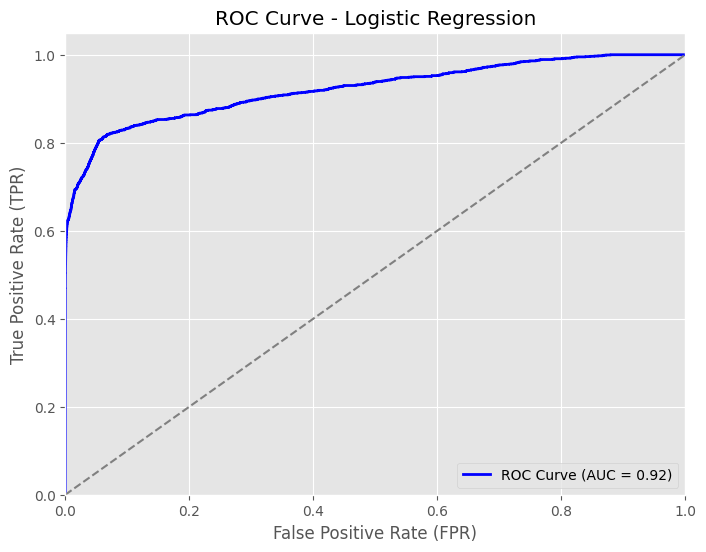

In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, auc

# Get probabilities for ROC Curve
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)
y_prob = logistic_model.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC score
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (random chance)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve - Logistic Regression')
plt.legend(loc='lower right')
plt.show()


The AUC score shows how well the model distinguishes between fraudulent and legitimate transactions.

A higher AUC such as 0.92 represents better fraud detection. However, to have a granular view into the prediction segmentation, plotting a confusion matrix is the method we can use.

<Figure size 600x600 with 0 Axes>

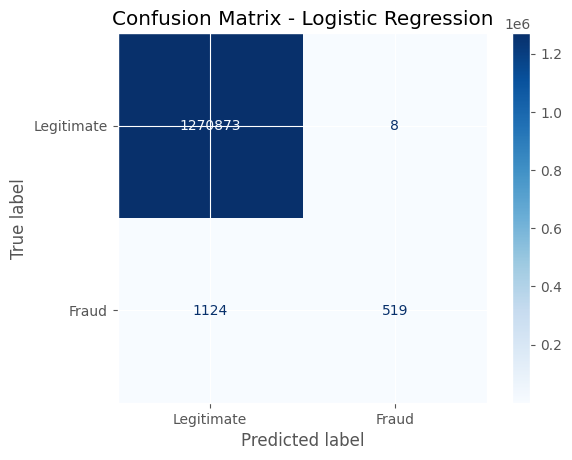

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict values using the trained logistic regression model
y_pred = logistic_model.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display confusion matrix
plt.figure(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Legitimate", "Fraud"])
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()


In the above confusion matrix for a logistic regression model, the model predicts 519 true labels while predicting 1124 fraud labels as legitimate. This shows that the model picks up legitimate labels with the highest precision of about 98% but has a very low recall of 31%.



### Training Random Forest Classifier to adjust recall

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Train a Random Forest Classifier (Better for imbalanced fraud detection)
rf_model = RandomForestClassifier(n_estimators=5, max_depth=10, random_state=42, class_weight="balanced")
rf_model.fit(X_train, y_train)

# Predict on test set
y_pred_rf = rf_model.predict(X_test)

# Get classification report
report = classification_report(y_test, y_pred_rf, target_names=["Legitimate", "Fraud"])

# Display classification report
print("Random Forest Model Performance:")
print(report)


Random Forest Model Performance:
              precision    recall  f1-score   support

  Legitimate       1.00      0.98      0.99   1270881
       Fraud       0.06      0.99      0.11      1643

    accuracy                           0.98   1272524
   macro avg       0.53      0.98      0.55   1272524
weighted avg       1.00      0.98      0.99   1272524



<Figure size 600x600 with 0 Axes>

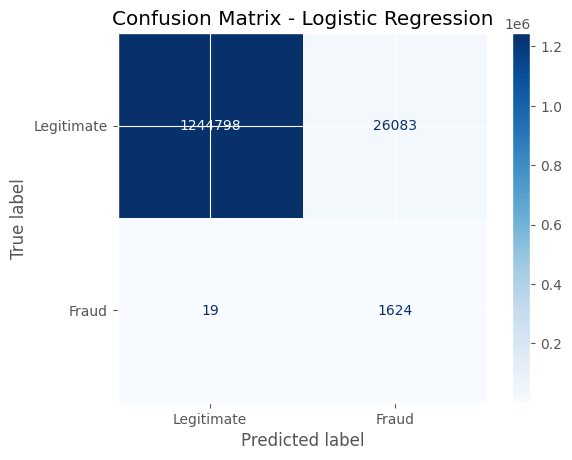

In [ ]:
cm_rf = confusion_matrix(y_test, y_pred_rf)
# Display confusion matrix
plt.figure(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=["Legitimate", "Fraud"])
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

**Explanation of the Confusion Matrix**

True Negatives (TN): 1,244,798
Legitimate transactions correctly classified as legitimate.

False Positives (FP): 26,083
Legitimate transactions incorrectly classified as fraud.
These represent false alarms, which can disrupt user experience and create unnecessary overhead.

True Positives (TP): 1,624
Fraudulent transactions correctly identified as fraud.
Capturing these transactions is the primary objective of the model.

False Negatives (FN): 19
Fraudulent transactions incorrectly classified as legitimate.
These are missed fraud cases, which pose financial and reputational risks.


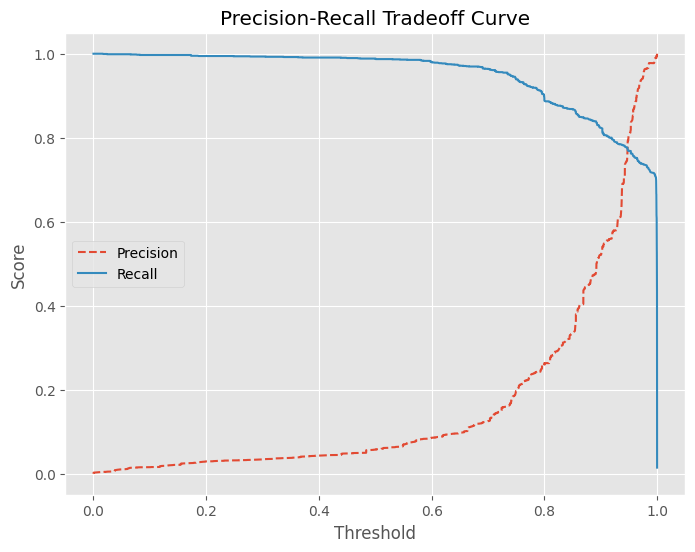

In [ ]:
from sklearn.metrics import precision_recall_curve

# Get fraud probabilities
y_scores = rf_model.predict_proba(X_test)[:, 1]

# Compute precision-recall curve
precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precisions[:-1], label="Precision", linestyle="--")
plt.plot(thresholds, recalls[:-1], label="Recall", linestyle="-")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision-Recall Tradeoff Curve")
plt.legend()
plt.show()


In [ ]:
# Calculate F1 score for each threshold
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)  # Adding small value to avoid division by zero
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

# Display the best threshold and corresponding metrics
best_precision = precisions[best_idx]
best_recall = recalls[best_idx]
best_f1 = f1_scores[best_idx]

best_threshold, best_precision, best_recall, best_f1


(0.9781339550887779,
 0.9633466135458167,
 0.7358490566037735,
 0.8343685299716002)

<Figure size 600x600 with 0 Axes>

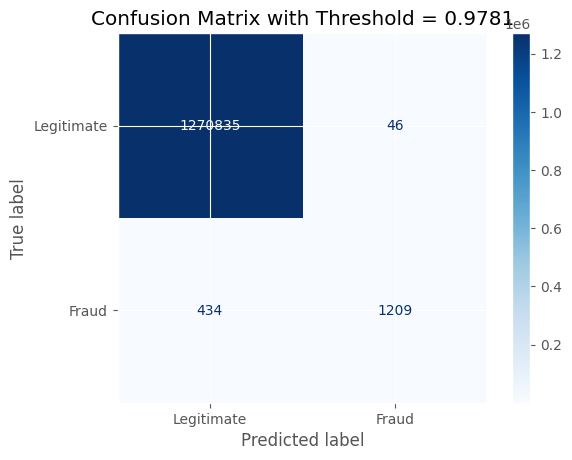

(0.9633466135457399, 0.7358490566037288, 0.8343685299715425)

In [ ]:
# Apply the new threshold to make predictions
new_threshold = 0.9781
y_pred_new = (y_scores >= new_threshold).astype(int)

# Compute confusion matrix with the new threshold
cm_new = confusion_matrix(y_test, y_pred_new)

# Display the confusion matrix
plt.figure(figsize=(6, 6))
disp_new = ConfusionMatrixDisplay(confusion_matrix=cm_new, display_labels=["Legitimate", "Fraud"])
disp_new.plot(cmap="Blues", values_format="d")
plt.title(f"Confusion Matrix with Threshold = {new_threshold}")
plt.show()

# Calculate and display precision, recall, and F1-score for the new threshold
precision_new = cm_new[1, 1] / (cm_new[1, 1] + cm_new[0, 1] + 1e-10)
recall_new = cm_new[1, 1] / (cm_new[1, 1] + cm_new[1, 0] + 1e-10)
f1_new = 2 * (precision_new * recall_new) / (precision_new + recall_new + 1e-10)

precision_new, recall_new, f1_new


High Precision (96.3%): The threshold adjustment significantly reduces false positives, minimising disruptions for legitimate users.
Overall accuracy remains very high.

Recall (73.5%): The model misses more fraud cases compared to a lower threshold.

The tradeoff between precision and recall means that some fraud cases may go undetected.

Balance Achieved:
This threshold optimises for precision, making the model more reliable in its fraud predictions, but at the expense of missing some fraudulent cases.


In [ ]:
import joblib

# Assuming your model is trained as logistic_model
joblib.dump(rf_model, "fraud_detection_model.pkl")


['fraud_detection_model.pkl']